# Inverse Designed Grating Coupler

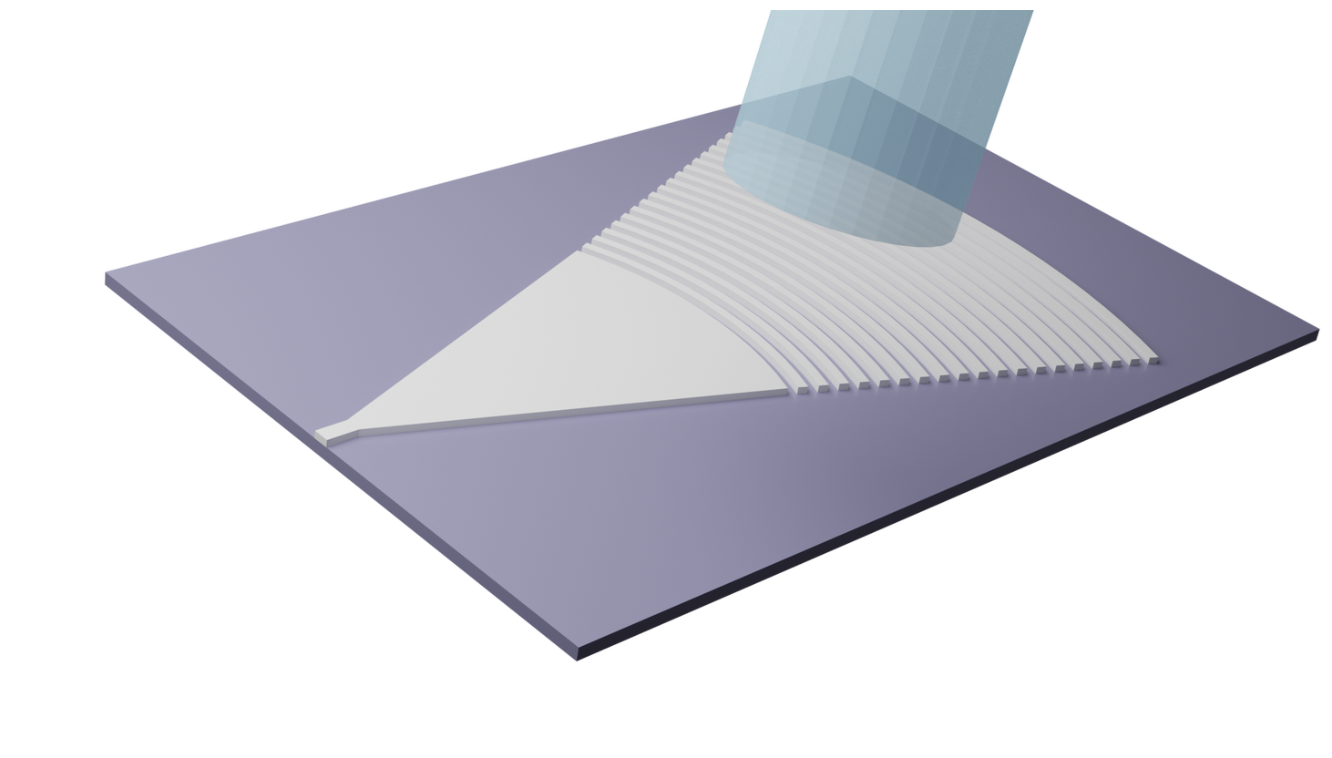

In this notebook, we demonstrate an example of fabrication-aware inverse design using [PhotonForge](https://www.flexcompute.com/photonforge) in conjunction with Tidy3D’s [inverse design framework](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Overview/).

[PhotonForge](https://www.flexcompute.com/photonforge) is an end-to-end photonic design automation platform that accelerates photonic integrated circuit development by seamlessly integrating simulation tools, layout editing, circuit-level system modeling, and foundry PDKs into one unified workflow. Tidy3D’s [inverse design framework](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Overview/) enables efficient computation of the derivative of a figure of merit (such as transmission) with respect to any number of design parameters. Together, these tools provide a powerful and streamlined design automation workflow for optimizing photonic components.

In this example, we use PhotonForge and inverse design to optimize a grating coupler. The initial grating coupler structure is based on [this PhotonForge example](../examples/Grating_Coupler.rst), which follows the design presented in [1].

For additional examples of inverse-designed grating couplers, see [this](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd6GratingCoupler.html) and [this](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd19ApodizedCoupler.html) Tidy3D notebook.

For a broader overview of inverse design in Tidy3D, refer to the [Inverse Design Quickstart](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Quickstart/). More in-depth examples are also available [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/docs/features/autograd.html).

**References**

1. Frederik Van Laere, Tom Claes, Jonathan Schrauwen, Stijn Scheerlinck, Wim Bogaerts, Dirk Taillaert, Liam O’Faolain, Dries Van Thourhout, Roel Baets, “Compact Focusing Grating Couplers for Silicon-on-Insulator Integrated Circuits,” *IEEE Photonics Technology Letters*, 2007 19 (23), 1919–1921, doi: [10.1109/LPT.2007.908762](https://doi.org/10.1109/LPT.2007.908762)


The general workflow for this notebook is summarized below:

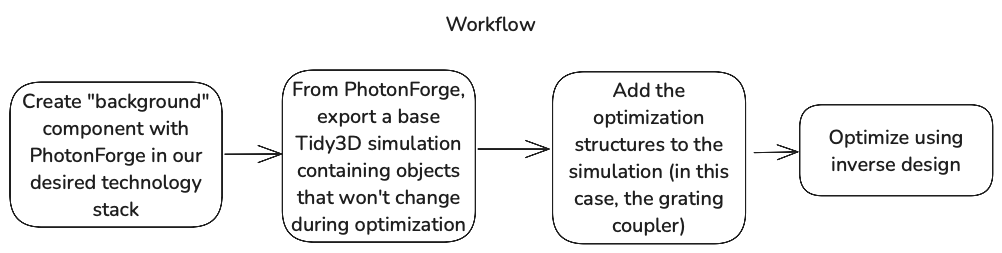


In [1]:
from functools import partial

import autograd as ag
import autograd.numpy as np  # Important to import autograd's numpy module for tracing derivatives
import optax
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d.plugins.autograd import smooth_min

# Set the default PhotonForge -> Tidy3D mesh refinement
# We are running 2D simulations, so this can be set rather high
pf.config.default_mesh_refinement = 30.0

## Technology Setup

In the first part of this notebook, we set up the [technology](../guides/Technology.rst) stack.

The technology used in the reference work [1] is similar to PhotonForge’s [basic technology](../_autosummary/photonforge.basic_technology.rst), with two key differences: the slab thickness and the absence of the top cladding.

To emulate the 70 nm etch depth from the reference design, we set the `slab_thickness` to 150 nm:

In [2]:
tech = pf.basic_technology(slab_thickness=0.15)
pf.config.default_technology = tech

We can view the layers and extrusions provided by the technology

In [3]:
tech.layers

Name   Layer             Description               Color    Pattern
---------------------------------------------------------------------
WG_CLAD  (1, 0)  Waveguide clad                    #9da6a218     .   
WG_CORE  (2, 0)  Waveguide core                    #6db5dd18     /   
SLAB     (3, 0)  Slab region                       #8851ad18     :   
TRENCH   (4, 0)  Deep-etched trench for chip fac…  #535e5918     +   
METAL    (5, 0)  Metal layer                       #b8a18b18     \

In [4]:
tech.extrusion_specs

#     Mask    Limits (μm)  Sidewal (°)            Opt. Medium                    Elec. Medium      
---------------------------------------------------------------------------------------------------
0  'WG_CORE'    0, 0.22         0       PoleResidue(frequency_range=(21…  Medium(permittivity=12.3)
1  'SLAB'       0, 0.15         0       PoleResidue(frequency_range=(21…  Medium(permittivity=12.3)
2  'METAL'     1.72, 2.22       0       PoleResidue(frequency_range=(15…  PEC                      
3  'TRENCH'    -inf, inf        0       Medium()                          Medium()

Unfortunately, there is no direct argument to remove the top cladding in the basic technology, because both the top and bottom media are defined by the background medium. Additionally, setting the top cladding thickness to zero is not an option, since it is used internally to define the port dimensions.

A better approach is to add a new [extrusion specification](../_autosummary/photonforge.ExtrusionSpec.rst) to the technology. This specification will create an extra air volume above the substrate with infinite vertical extent. We can achieve this using the [insert_extrusion_spec](../_autosummary/photonforge.Technology.rst#photonforge.Technology.insert_extrusion_spec) method:



In [5]:
# An empty mask covers the whole device bounds
air_extrusion = pf.ExtrusionSpec(
    pf.MaskSpec(), td.Medium(permittivity=1.0, name="air"), limits=(0, pf.Z_INF)
)

# Insert air volume first, so that all core extrusions override the air clad
tech.insert_extrusion_spec(0, air_extrusion)

# Print the updated extrusion specs
tech.extrusion_specs

#     Mask    Limits (μm)  Sidewal (°)            Opt. Medium                    Elec. Medium      
---------------------------------------------------------------------------------------------------
0  ()            0, inf         0       air                               air                      
1  'WG_CORE'    0, 0.22         0       PoleResidue(frequency_range=(21…  Medium(permittivity=12.3)
2  'SLAB'       0, 0.15         0       PoleResidue(frequency_range=(21…  Medium(permittivity=12.3)
3  'METAL'     1.72, 2.22       0       PoleResidue(frequency_range=(15…  PEC                      
4  'TRENCH'    -inf, inf        0       Medium()                          Medium()

## Grating Coupler Adjoint Optimization

Next, let's set up the grating coupler adjoint optimization. In this workflow, we use PhotonForge to construct the initial Tidy3D model. The benefit of this approach is that PhotonForge automatically generates Tidy3D geometry layers based on the technology stack and extrusion specifications. PhotonForge creates the initial simulation setup, which we will then modify for the adjoint optimization.

### Background Simulation Setup with PhotonForge

We begin by creating a starting simulation using PhotonForge. This simulation includes all structures that remain fixed during optimization—such as the background layer stack (input waveguide, cladding oxide, and air), the Gaussian beam source, and the waveguide monitor.

To build the simulation, we define a PhotonForge component that:
1. Draws the background structures using the specified technology stack.
2. Generates an initial Tidy3D simulation model, which we will later update for adjoint optimization.

Below are the setup parameters for the component:

**Note**: Since we are working in **2D**, the `wg_width` represents the extent of the waveguide in the invariant y-direction and does not impact the actual guided mode profile. The simulation will be carried out in the x–z plane.


In [6]:
# Setup parameters
wg_width = 6  # This is arbitrary because the simulation is 2D
wg_length = 30
fiber_angle = 10
fiber_translation = 3
waist_radius = 6.0
gaussian_port_height = 0.5

# Define the gaussian port input vector based on the fiber angle
sin_angle = np.sin(fiber_angle / 180 * np.pi)
cos_angle = np.cos(fiber_angle / 180 * np.pi)
input_vector = (-sin_angle, 0, -cos_angle)

Next, we create the background PhotonForge component and add the input waveguide as a rectangle.

In [7]:
# Create an empty Photonforge component
background = pf.Component()

# Add the waveguide layer
wg = pf.Rectangle((0, -wg_width / 2), (wg_length, wg_width / 2))
background.add("WG_CORE", wg)

We then add two ports: one Gaussian port positioned above the center of the grating, and another at the input of the waveguide. 

The Gaussian port will be converted to a Gaussian source, and the waveguide port will be converted to a mode monitor when PhotonForge generates the Tidy3D simulation.


In [8]:
# Add the waveguide port
input_wg_portspec = pf.PortSpec(
    "input wg",
    width=wg_width,
    limits=tech.ports["Strip"].limits,
    num_modes=1,
    target_neff=3.5,
    path_profiles={(wg_width, 0, tech.layers["WG_CORE"].layer)},
)
background.add_port(pf.Port((0, 0), 0, input_wg_portspec))

# Add the fiber (gaussian) port
gaussian_port_center = (wg_length / 2 + fiber_translation, 0, gaussian_port_height)
background.add_port(
    pf.GaussianPort(
        gaussian_port_center,
        input_vector,
        waist_radius,
        polarization_angle=90,
        field_tolerance=1e-2,
    )
)

'P1'

We can now see that the two ports have been added to the component:

In [9]:
background

Now we add a Tidy3D simulation model to the component. This model will generate the initial Tidy3D simulation, which serves as the starting point for the adjoint optimization.

In [10]:
# Add a Tidy3D simulation model to the component
background.add_model(pf.Tidy3DModel(), "Tidy3D")

'Tidy3D'

From the model we just added to the component, we extract the base simulation for optimization.

PhotonForge generates one simulation for each source port. Here, we select the simulation labeled `"P1@0"`, which corresponds to port `P1` being used as the excitation source. This is the simulation we will modify during the optimization process.


In [11]:
wavelengths = np.linspace(1.5, 1.6, 21)
sims = background.models["Tidy3D"].get_simulations(background, pf.C_0 / wavelengths)

# Select the simulation where port P1 is used as the source
basesim = sims["P1@0"]  # This will be the base simulation that we work with

Let's view this simulation:

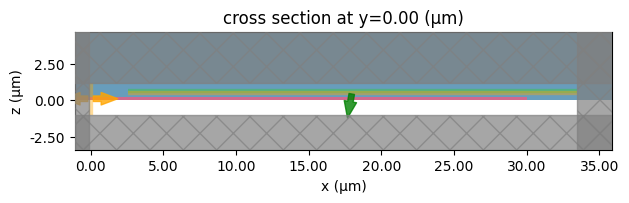

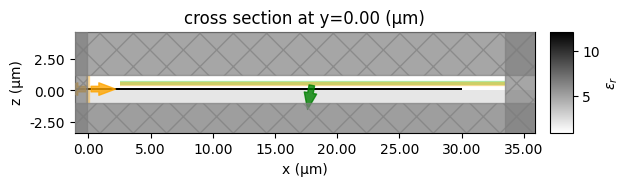

In [12]:
basesim.plot(y=0)
basesim.plot_eps(y=0)
plt.show()

We can see that PhotonForge has automatically generated the simulation contains background structures for this technology stack, and has added a Gaussian beam source (green) and a waveguide mode monitor (orange).

## Grating Coupler Simulation

Now that we have our base simulation with all static structures, we can modify it to include the grating region and run 2D grating simulations.

First, we convert the base simulation from 3D to 2D. We also remove the field monitor placed below the Gaussian source, as it is not required for the optimization (PhotonForge adds it automatically for S-parameter calculations).


In [13]:
# Update the simulation size so that it is 2D
size = (basesim.size[0], 0, basesim.size[2])

# Update the boundary spec for 2D simulations
boundary_spec = basesim.boundary_spec.updated_copy(
    y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
)

basesim = basesim.updated_copy(
    size=size,
    boundary_spec=boundary_spec,
)

The size of the simulation is now two dimensional:

In [14]:
print(basesim.size)

(33.534, 0.0, 2.222)


Next, we add in the grating coupler structure. Below are the starting parameters for our grating coupler, taken from \[1]. 

In [15]:
period = 0.63        # Grating period in microns
gc_len = 15.5        # Total grating length in microns
ncells = int(round(gc_len / period))  # Number of grating periods
fill_factor = 0.5    # Filling factor at each period

# Initial grating structure: uniform fill factor
gc_widths = np.ones(shape=ncells) * period * fill_factor
gc_gaps = period - gc_widths

To determine the z-bounds of the grating etch, we extract the `slab_thickness` and `core_thickness` from the technology definition.

The etch region spans from the top of the slab to the top of the waveguide core.

In [16]:
# Get thickness values from the technology's parametric definition
slab_thickness = tech.parametric_kwargs["slab_thickness"]
core_thickness = tech.parametric_kwargs["core_thickness"]

# Define core and slab z-bounds (assume waveguide core starts at z = 0)
corebounds = (0, core_thickness)
slabbounds = (0, slab_thickness)

# The etched region spans from top of slab to top of core
etch_zbounds = (slabbounds[1], corebounds[1]) 

Next, we define a function that adds the grating teeth to the simulation. This function constructs a 2D grating geometry using the specified gap and width arrays, and appends it to the base simulation.


In [17]:
def gc_sim(
    gc_gaps: np.ndarray,
    gc_widths: np.ndarray,
    basesim: td.Simulation = basesim,
    gc_startx: float = 5,
):
    """Returns a 2D grating simulation for optimization.

    Parameters
    ----------
    gc_gaps : np.ndarray
        Widths of the partially etched regions.
    gc_widths : np.ndarray
        Widths of the unetched regions.
    basesim : td.Simulation
        Base simulation to update.
    gc_startx : float
        x-coordinate where the grating starts.
    """
    # Add the grating teeth to the simulation
    grating_structures = []
    cx = gc_startx
    for w, g in zip(gc_widths, gc_gaps):
        cx += g / 2
        grating_structures.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(cx - g / 2, -td.inf, etch_zbounds[0]),
                    rmax=(cx + g / 2, td.inf, etch_zbounds[1]),
                ),
                medium=td.Medium(permittivity=1.0),
            )
        )
        cx += g / 2 + w

    # Combine with existing structures
    structures = list(basesim.structures) + grating_structures

    # Etch away the remaining waveguide layer after the grating
    structures.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(cx, -td.inf, corebounds[0]),
                rmax=(1e3, td.inf, corebounds[1]),
            ),
            medium=td.Medium(permittivity=1.0),
        )
    )

    return basesim.updated_copy(structures=structures)


Let's test the grating coupler simulation to ensure it is working correctly. We start by visualizing the simulation with the grating structure added.

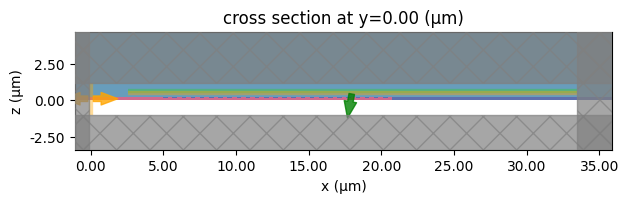

In [18]:
# test gc sim
testsim = gc_sim(
    gc_gaps,
    gc_widths,
)

testsim.plot(y=0)
plt.show()

The source position is likely not optimal for high coupling efficiency, but we can run the simulation to ensure there are no setup errors.

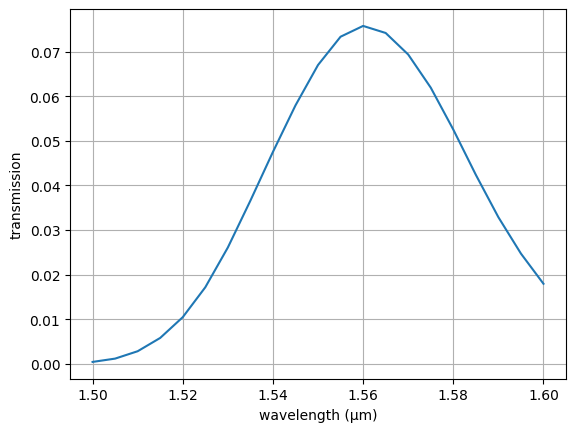

In [19]:
# Run the simulation
sim_data = td.web.run(testsim, task_name="testgc", path="simdata/data.hdf5", verbose=False)

# Plot transmission from the Gaussian source to the waveguide port
amps = sim_data["P0"].amps.sel(direction="-")
T = amps.abs**2

f, ax = plt.subplots()
ax.plot(td.C_0 / T.f, T)
ax.set_xlabel("wavelength (µm)")
ax.set_ylabel("transmission")
ax.grid()


The initial simulation looks correct. 

Now let's sweep the source position and find the position for the best coupling.

In [20]:
# sweep source position for best coupling
fiber_pos = np.linspace(5, 15, 11)

# Generate simulations with updated fiber source positions
sims = []
for fpos in fiber_pos:
    source = testsim.sources[0]
    source = source.updated_copy(center=(fpos, source.center[1], source.center[2]))
    sims.append(testsim.updated_copy(sources=[source]))

# Consolidate simulations into a dict for passing to td.web.run_async
gcsims = {f"fiber_pos{fpos}": sim for fpos, sim in zip(fiber_pos, sims)}

# Run the batch of simulations.
batchdata = td.web.run_async(gcsims, path_dir="simdata", verbose=False)

In [21]:
# Get transmission at the center wavelength vs. source position
centerwl = 1.55
T_centerwl = []
for key, simdata in batchdata.items():
    amps = simdata["P0"].amps.sel(direction="-")
    T = amps.abs**2
    T_centerwl.append(T.interp(f=td.C_0 / centerwl).data[0])

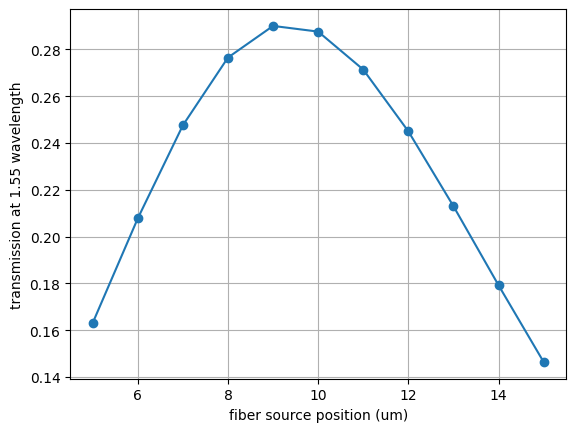

In [22]:
f, ax = plt.subplots()
ax.plot(fiber_pos, T_centerwl, "-o")
ax.set_xlabel("fiber source position (um)")
ax.set_ylabel(f"transmission at {centerwl} wavelength")
ax.grid()
plt.show()

It looks like a good source position is around 9 µm. Let's update the base simulation with this optimal source position. With that in place, we're ready to proceed with adjoint optimizations.


In [23]:
# update source position
best_fiber_pos = fiber_pos[np.argmax(T_centerwl)]
source = basesim.sources[0]
source = source.updated_copy(center=(best_fiber_pos, source.center[1], source.center[2]))
basesim = basesim.updated_copy(sources=[source])

## Adjoint Optimization

We start by defining an objective function to optimize. In this case, the objective is to maximize the worst-case transmission within a specified wavelength range.

To ensure compatibility with gradient-based optimization, we use the `smooth_min()` function, which provides a differentiable approximation of the minimum value across a set. Differentiability is essential for gradient descent methods to work effectively.


In [24]:
def worstloss(simdata, wl_range):
    """Returns the worst transmission across measured frequencies from the monitor"""
    freqrange = td.C_0 / np.array(wl_range)
    amps = simdata["P0"].amps.sel(direction="-", f=slice(freqrange[0], freqrange[1])).data
    T = np.abs(amps) ** 2
    return smooth_min(T, tau=1e-2)

To use this objective function with Autograd—which handles differentiation through general Python code—we must define the optimization parameters as a single array and pass them as positional arguments to the objective function. For an overview of how Autograd fits into the Tidy3D inverse design pipeline, see [this article](https://hs.flexcompute.com/adjoint-for-tidy3d).

Before defining the objective function, we'll create two helper functions to convert between a design dictionary and a flat NumPy array. This will make it easier to manage the design parameters both inside and outside the optimization loop.


In [25]:
def design_to_array(design: dict[str, np.ndarray]) -> tuple[np.ndarray, tuple[int, int]]:
    """Converts design parameters into a single array"""
    gc_gaps = design["gc_gaps"]
    gc_widths = design["gc_widths"]
    array = np.hstack([gc_gaps, gc_widths])
    lengths = (
        len(gc_gaps),
        len(gc_widths),
    )
    return array, lengths


def array_to_design(array: np.ndarray, lengths: tuple[int, int]) -> dict[str, np.ndarray]:
    """Converts array back to design parameters"""
    len_gaps, len_widths = lengths
    idx = 0
    design = {}
    design["gc_gaps"] = array[idx : idx + len_gaps]
    idx += len_gaps
    design["gc_widths"] = array[idx : idx + len_widths]
    return design

Now we define the objective function, which wraps the loss function in a form compatible with Autograd. The function:

1. Accepts the optimization parameters as a single NumPy array and converts them back to a design dictionary.
2. Creates and runs a simulation using those design parameters.
3. Computes and returns the objective value (e.g., worst-case transmission loss).


In [26]:
def objective(params_array: np.ndarray, param_lengths, wl_range):
    """The objective function for optimization. Creates the simulation, and returns the loss."""
    # first convert the parameter array to a dictionary for passing to the simulation maker
    design = array_to_design(params_array, param_lengths)

    # then create and run the simulation
    sim = gc_sim(**design, basesim=basesim)
    simdata = td.web.run(sim, task_name="gcopt", path="simdata/gc.hdf5", verbose=False)

    # finally return the objective value
    return worstloss(simdata, wl_range=wl_range)

In a real photonic integrated circuit (PIC) platform, there are minimum feature size constraints. These include:

- **Minimum line width**: the smallest allowable feature width (e.g., for etched or deposited material).
- **Minimum space (gap)**: the smallest allowable spacing between features.

We define these constraints and enforce them inside the optimization loop using parameter clipping. Clipping ensures that no design parameter violates the minimum line or gap rules.


In [27]:
min_line = 0.15
min_space = 0.2


def minfeat_cliparray(design, min_line=min_line, min_space=min_space):
    """This function returns a single array of minimum line and space for clipping."""
    _, param_lengths = design_to_array(design)
    min_spaces = min_space * np.ones(shape=param_lengths[0])
    min_lines = min_line * np.ones(shape=param_lengths[1])
    return np.concatenate((min_spaces, min_lines))

Now we assemble the various components into the main optimization loop.

In addition to the starting design and objective function, we also define hyperparameters such as the number of optimization steps, learning rate, and the optimizer. We use the Adam algorithm from the [Optax package](https://optax.readthedocs.io/en/latest/), which is well-suited for gradient-based optimization.

Tidy3D's adjoint solver—combined with Autograd—automatically evaluates gradients via the chain rule through general Python code. The optimizer (Optax in this case) then updates the parameters at each step using these gradients.


In [33]:
# The wavelength range to optimize for
wl_range = (1.545, 1.555)

# Optimization parameters
learning_rate = 1e-2
num_steps = 40

# The starting grating design
design0 = {
    "gc_gaps": gc_gaps,
    "gc_widths": gc_widths,
}

# Choice of optimizer to use
optimizer = optax.adam

# Initialize the optimizer with starting parameters
params_array0, param_lengths = design_to_array(design0)
params_array = np.array(params_array0).copy()
optimizer = optimizer(learning_rate=learning_rate)
opt_state = optimizer.init(params_array)

# Create the minimum feature size array for clipping
minfeatarr = minfeat_cliparray(design=design0)

# Arrays that store the optimization history
objective_history = []
param_history = [params_array]
gradient_history = []

# To use Autograd to calculate the gradient of our objective function, we wrap it within
# Autograd's value_and_grad() function.
obj_fun = partial(objective, param_lengths=param_lengths, wl_range=wl_range)
grad_fn = ag.value_and_grad(obj_fun)

We now run the optimization for 40 iterations with a learning rate of 1e-2, targeting a narrow 10 nm bandwidth from 1545 nm to 1555 nm. Feel free to experiment with the learning rate, step count, or bandwidth range based on your application.


In [29]:
for ii in range(num_steps):
    print(f"step = {ii + 1}")

    # Evaluate the current value and gradient of our objective function with the current parameters.
    value, gradient = grad_fn(params_array)

    # Print the outputs
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # Compute and apply updates to the parameters based on the computed gradient.
    # The Optax Adam optimizer is used to compute and apply the updates.
    # Note that the gradient is negated for maximizing the objective (the default behavior is to minimize).
    updates, opt_state = optimizer.update(-gradient, opt_state, params_array)
    params_array = optax.apply_updates(params_array, updates)
    params_array = np.array(params_array)

    # Enforce DRC constraints by clipping the parameters.
    np.clip(params_array, minfeatarr, None, out=params_array)

    # Save the results of this iteration step to the history.
    objective_history.append(value)
    param_history.append(params_array)
    gradient_history.append(gradient)

step = 1
	J = 2.6875e-01
	grad_norm = 2.7844e+00
step = 2
	J = 1.7482e-01
	grad_norm = 4.3962e+00
step = 3
	J = 2.4174e-01
	grad_norm = 3.5628e+00
step = 4
	J = 2.9479e-01
	grad_norm = 1.0747e+00
step = 5
	J = 2.4486e-01
	grad_norm = 3.4810e+00
step = 6
	J = 2.4816e-01
	grad_norm = 3.3931e+00
step = 7
	J = 2.8747e-01
	grad_norm = 1.8932e+00
step = 8
	J = 2.9107e-01
	grad_norm = 1.6187e+00
step = 9
	J = 2.6748e-01
	grad_norm = 2.8399e+00
step = 10
	J = 2.6989e-01
	grad_norm = 2.7722e+00
step = 11
	J = 2.9043e-01
	grad_norm = 1.6708e+00
step = 12
	J = 2.9712e-01
	grad_norm = 8.3142e-01
step = 13
	J = 2.8138e-01
	grad_norm = 2.3528e+00
step = 14
	J = 2.7857e-01
	grad_norm = 2.5038e+00
step = 15
	J = 2.9163e-01
	grad_norm = 1.4818e+00
step = 16
	J = 2.9914e-01
	grad_norm = 4.5491e-01
step = 17
	J = 2.9055e-01
	grad_norm = 1.5387e+00
step = 18
	J = 2.8647e-01
	grad_norm = 1.9125e+00
step = 19
	J = 2.9191e-01
	grad_norm = 1.4884e+00
step = 20
	J = 2.9868e-01
	grad_norm = 5.3997e-01
step = 21

Once the optimization is complete we can view the results:

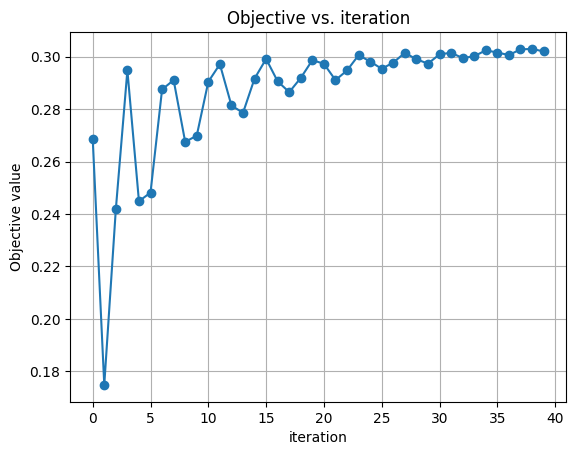

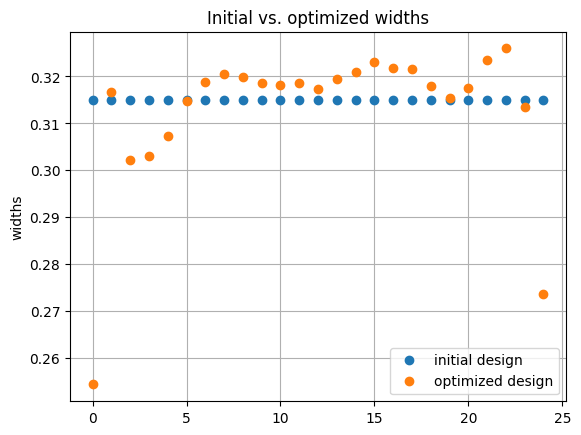

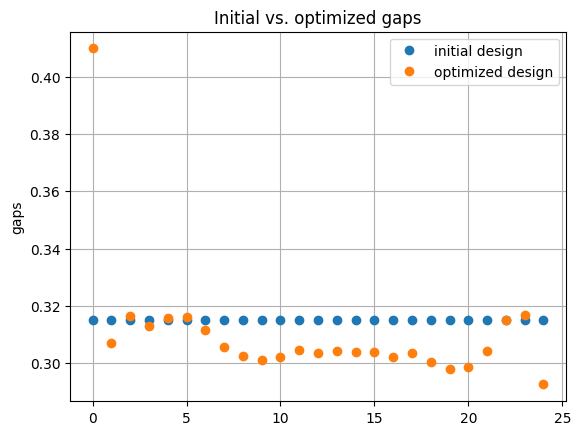

In [30]:
# Plot the objective value versus iteration.
f, ax = plt.subplots()
ax.plot(objective_history, "-o")
ax.set_xlabel("iteration")
ax.set_ylabel("Objective value")
ax.grid()
ax.set_title("Objective vs. iteration")

# Select the best design parameters.
best_params = param_history[np.argmax(objective_history)]
_, param_lengths = design_to_array(design0)
best_design = array_to_design(best_params, param_lengths)

# Compare the starting and final params.
f, ax = plt.subplots()
ax.plot(design0["gc_widths"], "o", label="initial design")
ax.plot(best_design["gc_widths"], "o", label="optimized design")
ax.set_ylabel("widths")
ax.grid()
ax.legend()
ax.set_title("Initial vs. optimized widths")

f, ax = plt.subplots()
ax.plot(design0["gc_gaps"], "o", label="initial design")
ax.plot(best_design["gc_gaps"], "o", label="optimized design")
ax.set_ylabel("gaps")
ax.grid()
ax.legend()
ax.set_title("Initial vs. optimized gaps")

plt.show()

Finally, we can simulate the optimized design, and compare it with the initial design.

In [31]:
sim_startdesign = gc_sim(**design0, basesim=basesim)
simdata_startdesign = td.web.run(
    sim_startdesign, task_name="gcopt", path="simdata/gcstart.hdf5", verbose=False
)
sim_bestdesign = gc_sim(**best_design, basesim=basesim)
simdata_bestdesign = td.web.run(
    sim_bestdesign, task_name="gcopt", path="simdata/gcbest.hdf5", verbose=False
)

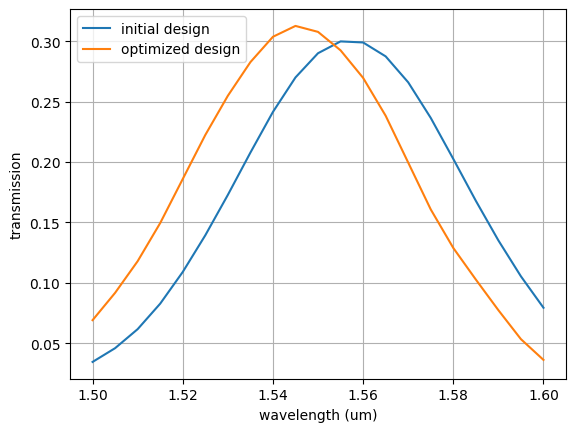

In [32]:
# Plot final transmission, compare to the initial design
amps_startdesign = simdata_startdesign["P0"].amps.sel(direction="-")
T_startdesign = amps_startdesign.abs**2
amps_bestdesign = simdata_bestdesign["P0"].amps.sel(direction="-")
T_bestdesign = amps_bestdesign.abs**2

f, ax = plt.subplots()
ax.plot(td.C_0 / T_startdesign.f, T_startdesign, label="initial design")
ax.plot(td.C_0 / T_bestdesign.f, T_bestdesign, label="optimized design")
ax.set_xlabel("wavelength (um)")
ax.set_ylabel("transmission")
ax.grid()
ax.legend()

plt.show()

We can see that the final design has centered the transmission spectrum on our design wavelength, and slightly improved the coupling efficiency. More improvement could be possible by experimenting with the optimization hyperparameters, such as the starting design or the coupling bandwidth. Feel free to experiment if you would like and see if you can improve the design even more.